In [90]:
# Instalación de dependencias
# !pip install numpy scipy matplotlib seaborn scikit-learn mesa -q

# Imports
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import numpy as np
import pandas as pd
import seaborn as sns
import random
import copy
import heapq
sns.set()


# Configuración del mapa (igual que antes)
bits = [
    ["00110","00100","00100","00100","01103","00113","01103","01113"],
    ["10010","10000","10000","10003","11000","10010","11000","11010"],
    ["00110","01100","00110","00103","00100","01103","00113","01100"],
    ["00010","01003","10013","10000","10000","11000","10010","11003"],
    ["00010","00000","01100","00110","01103","00113","00100","01103"],
    ["10010","10000","11003","10013","11000","10010","10000","11000"],
]

def decode(cell):
    if cell[4] == "3":
        estado = "cerrado"
    elif cell[4] == "4":
        estado = "abierto"
    else:
        estado = "sin_puerta"

    return {
        "up": cell[0] == "1",
        "right": cell[1] == "1",
        "down": cell[2] == "1",
        "left": cell[3] == "1",
        "vida": 2,
        "puerta": estado
    }

def can_move(model, x, y, nx, ny):
    if not (0 <= nx < model.grid.width and 0 <= ny < model.grid.height):
        return False

    cell = model.walls[y][x]
    next_cell = model.walls[ny][nx]

    dx = nx - x
    dy = ny - y

    if dy == 1:
        if cell["puerta"] == "cerrado" and cell["up"]:
            return "puerta_cerrada"
        if not cell["up"] or cell["vida"] <= 0:
            return True
        if cell["puerta"] in ["abierto", "sin_puerta"] and not cell["up"]:
            return True
        return False

    if dy == -1:
        if cell["puerta"] == "cerrado" and cell["down"]:
            return "puerta_cerrada"
        if not cell["down"] or cell["vida"] <= 0:
            return True
        if cell["puerta"] in ["abierto", "sin_puerta"] and not cell["down"]:
            return True
        return False

    if dx == 1:
        if cell["puerta"] == "cerrado" and cell["right"]:
            return "puerta_cerrada"
        if not cell["right"] or cell["vida"] <= 0:
            return True
        if cell["puerta"] in ["abierto", "sin_puerta"] and not cell["right"]:
            return True
        return False

    if dx == -1:
        if cell["puerta"] == "cerrado" and cell["left"]:
            return "puerta_cerrada"
        if not cell["left"] or cell["vida"] <= 0:
            return True
        if cell["puerta"] in ["abierto", "sin_puerta"] and not cell["left"]:
            return True
        return False

    return False

def get_door_direction(x, y, nx, ny):
    dx = nx - x
    dy = ny - y

    if dy == 1:
        return "up"
    elif dy == -1:
        return "down"
    elif dx == 1:
        return "right"
    elif dx == -1:
        return "left"
    return None

# ==================== NUEVAS FUNCIONES PARA DIJKSTRA ====================

def calcular_costo_movimiento(model, x, y, nx, ny, carrying=False):
    """
    Calcula el costo en PA para moverse de (x,y) a (nx,ny)
    """
    move_result = can_move(model, x, y, nx, ny)
    
    if move_result == False:
        return float('inf')  # No se puede mover
    
    costo_base = 2 if carrying else 1
    
    # Si hay fuego en el destino, cuesta más
    if model.cells[nx][ny] == 2:
        costo_base = 2
    
    # Si hay una puerta cerrada, añadir el costo de abrirla
    if move_result == "puerta_cerrada":
        costo_base += 1
    
    return costo_base

def dijkstra(model, start, goal, carrying=False, open_doors=True):
    """
    Implementación de Dijkstra para encontrar el camino más corto
    start: tupla (x, y) posición inicial
    goal: tupla (x, y) posición objetivo
    carrying: bool, si está cargando una víctima
    open_doors: bool, si puede abrir puertas
    
    Retorna: (costo_total, lista_de_posiciones)
    """
    if start == goal:
        return (0, [start])
    
    # Cola de prioridad: (costo, posicion)
    pq = [(0, start)]
    # Diccionario de costos
    costos = {start: 0}
    # Diccionario de padres para reconstruir el camino
    padres = {start: None}
    
    while pq:
        costo_actual, pos_actual = heapq.heappop(pq)
        
        if pos_actual == goal:
            # Reconstruir camino
            camino = []
            pos = goal
            while pos is not None:
                camino.append(pos)
                pos = padres[pos]
            camino.reverse()
            return (costo_actual, camino)
        
        # Si ya encontramos un camino mejor, ignorar
        if costo_actual > costos.get(pos_actual, float('inf')):
            continue
        
        x, y = pos_actual
        vecinos = model.grid.get_neighborhood(pos_actual, moore=False, include_center=False)
        
        for nx, ny in vecinos:
            costo_movimiento = calcular_costo_movimiento(model, x, y, nx, ny, carrying)
            
            # Si no se puede abrir puertas y hay una puerta cerrada, no considerar
            if not open_doors and can_move(model, x, y, nx, ny) == "puerta_cerrada":
                continue
            
            # Si el costo es infinito, no se puede pasar
            if costo_movimiento == float('inf'):
                continue
            
            nuevo_costo = costo_actual + costo_movimiento
            
            if nuevo_costo < costos.get((nx, ny), float('inf')):
                costos[(nx, ny)] = nuevo_costo
                padres[(nx, ny)] = pos_actual
                heapq.heappush(pq, (nuevo_costo, (nx, ny)))
    
    # No hay camino
    return (float('inf'), [])

def encontrar_objetivo_mas_cercano(model, pos_agente, objetivos, carrying=False):
    """
    Encuentra el objetivo más cercano usando Dijkstra
    objetivos: lista de tuplas (x, y)
    
    Retorna: (objetivo, costo, camino)
    """
    mejor_objetivo = None
    mejor_costo = float('inf')
    mejor_camino = []
    
    for objetivo in objetivos:
        costo, camino = dijkstra(model, pos_agente, objetivo, carrying)
        if costo < mejor_costo:
            mejor_costo = costo
            mejor_objetivo = objetivo
            mejor_camino = camino
    
    return (mejor_objetivo, mejor_costo, mejor_camino)


In [91]:
# PARTE 2: Clase Cascanueces Modificada con Roles

class Cascanueces(Agent):
    def __init__(self, model, base_pos, rol="apagafuegos"):
        super().__init__(model)
        self.carrying = False
        self.PA = 4
        self.MAX_PA = 4
        self.PA_guardados = 0
        self.squares_visited = 0
        self.fuegos_apagados = 0
        self.humos_apagados = 0
        self.puertas_abiertas = 0
        self.base_pos = base_pos
        self.victimas_salvadas = 0
        self.veces_afectado_explosion = 0
        
        # NUEVO: Rol del agente
        self.rol = rol  # "apagafuegos" o "rescatista"
        self.objetivo_actual = None
        self.camino_actual = []
        
    def reset_pa(self):
        self.PA = self.MAX_PA + self.PA_guardados
        self.PA_guardados = 0
        
    def guardar_pa_no_usados(self):
        if self.PA > 0:
            self.PA_guardados = min(self.PA, 4)
        else:
            self.PA_guardados = 0

    def regresar_a_base(self):
        self.model.grid.move_agent(self, self.base_pos)
        if self.carrying:
            self.carrying = False
        self.veces_afectado_explosion += 1
        # Limpiar objetivo y camino al ser afectado
        self.objetivo_actual = None
        self.camino_actual = []

    def open_door(self, direction):
        if self.PA >= 1:
            x, y = self.pos
            cell = self.model.walls[y][x]

            if cell[direction] and cell["puerta"] == "cerrado":
                self.model.walls[y][x]["puerta"] = "abierto"
                self.PA -= 1
                self.puertas_abiertas += 1

                if direction == "up" and y + 1 < self.model.grid.height:
                    next_cell = self.model.walls[y + 1][x]
                    if next_cell["down"] and next_cell["puerta"] == "cerrado":
                        self.model.walls[y + 1][x]["puerta"] = "abierto"
                elif direction == "down" and y - 1 >= 0:
                    next_cell = self.model.walls[y - 1][x]
                    if next_cell["up"] and next_cell["puerta"] == "cerrado":
                        self.model.walls[y - 1][x]["puerta"] = "abierto"
                elif direction == "right" and x + 1 < self.model.grid.width:
                    next_cell = self.model.walls[y][x + 1]
                    if next_cell["left"] and next_cell["puerta"] == "cerrado":
                        self.model.walls[y][x + 1]["puerta"] = "abierto"
                elif direction == "left" and x - 1 >= 0:
                    next_cell = self.model.walls[y][x - 1]
                    if next_cell["right"] and next_cell["puerta"] == "cerrado":
                        self.model.walls[y][x - 1]["puerta"] = "abierto"

                return True
        return False
    
    def puede_apagar_adyacente(self):
        (x, y) = self.pos
        adyacentes = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )
        
        fuegos_adyacentes = []
        humos_adyacentes = []
        
        for (nx, ny) in adyacentes:
            if self.model.cells[nx][ny] == 2:
                fuegos_adyacentes.append((nx, ny))
            elif self.model.cells[nx][ny] == 1:
                humos_adyacentes.append((nx, ny))
        
        return fuegos_adyacentes, humos_adyacentes
    
    def apagar_adyacente(self, target_x, target_y):
        if self.model.cells[target_x][target_y] == 2 and self.PA >= 2:
            self.model.cells[target_x][target_y] = 0
            self.fuegos_apagados += 1
            self.model.fuegos_totales_apagados += 1
            self.PA -= 2
            return True
        elif self.model.cells[target_x][target_y] == 1 and self.PA >= 1:
            self.model.cells[target_x][target_y] = 0
            self.humos_apagados += 1
            self.PA -= 1
            return True
        return False

    def move(self, position):
        nx, ny = position
        costo = 1
        
        if self.model.cells[nx][ny] == 2:
            costo = 2
        elif self.carrying:
            costo = 2
        
        if self.PA >= costo:
            self.PA -= costo
            self.model.grid.move_agent(self, position)
            return True
        return False

    def descubrir_poi(self, x, y):
        if self.PA >= 1 and self.model.cells[x][y] == 3:
            self.PA -= 1

            poi_info = self.model.pois_info.get((x, y))

            if poi_info and poi_info['tipo'] == 'victima':
                self.model.cells[x][y] = 4
                return 'victima'
            elif poi_info and poi_info['tipo'] == 'falsa':
                self.model.cells[x][y] = 5
                self.model.cells[x][y] = 0
                self.model.pois_info.pop((x, y), None)
                self.model.falsas_alarmas_descubiertas += 1
                self.model.victimas_en_mapa -= 1
                self.model.spawn_nuevo_poi()
                return 'falsa'
        return None

    # ==================== NUEVAS FUNCIONES DE ESTRATEGIA ====================
    
    def encontrar_objetivos_rol(self):
        """
        Encuentra objetivos según el rol del agente
        """
        objetivos = []
        
        if self.rol == "apagafuegos":
            # Buscar fuegos y humos
            for x in range(self.model.grid.width):
                for y in range(self.model.grid.height):
                    if self.model.cells[x][y] == 2:  # Fuego
                        objetivos.append((x, y, 'fuego'))
                    elif self.model.cells[x][y] == 1:  # Humo
                        objetivos.append((x, y, 'humo'))
        
        elif self.rol == "rescatista":
            # Buscar POIs y víctimas
            for x in range(self.model.grid.width):
                for y in range(self.model.grid.height):
                    if self.model.cells[x][y] == 3:  # POI sin descubrir
                        objetivos.append((x, y, 'poi'))
                    elif self.model.cells[x][y] == 4:  # Víctima identificada
                        objetivos.append((x, y, 'victima'))
        
        return objetivos
    
    def seleccionar_objetivo(self):
        """
        Selecciona el mejor objetivo según el rol
        """
        if self.rol == "apagafuegos":
            objetivos = self.encontrar_objetivos_rol()
            if not objetivos:
                return None, None, []
            
            # Priorizar fuegos sobre humos
            fuegos = [(x, y) for x, y, tipo in objetivos if tipo == 'fuego']
            humos = [(x, y) for x, y, tipo in objetivos if tipo == 'humo']
            
            if fuegos:
                objetivo, costo, camino = encontrar_objetivo_mas_cercano(
                    self.model, self.pos, fuegos, self.carrying
                )
                return objetivo, 'fuego', camino
            elif humos:
                objetivo, costo, camino = encontrar_objetivo_mas_cercano(
                    self.model, self.pos, humos, self.carrying
                )
                return objetivo, 'humo', camino
        
        elif self.rol == "rescatista":
            # Si está cargando víctima, ir a la base más cercana
            if self.carrying:
                bases = [
                    self.model.pos_base1,
                    self.model.pos_base2,
                    self.model.pos_base3,
                    self.model.pos_base4
                ]
                objetivo, costo, camino = encontrar_objetivo_mas_cercano(
                    self.model, self.pos, bases, True
                )
                return objetivo, 'base', camino
            
            # Si no está cargando, buscar POIs o víctimas
            objetivos = self.encontrar_objetivos_rol()
            if not objetivos:
                return None, None, []
            
            # Priorizar víctimas identificadas sobre POIs
            victimas = [(x, y) for x, y, tipo in objetivos if tipo == 'victima']
            pois = [(x, y) for x, y, tipo in objetivos if tipo == 'poi']
            
            if victimas:
                objetivo, costo, camino = encontrar_objetivo_mas_cercano(
                    self.model, self.pos, victimas, False
                )
                return objetivo, 'victima', camino
            elif pois:
                objetivo, costo, camino = encontrar_objetivo_mas_cercano(
                    self.model, self.pos, pois, False
                )
                return objetivo, 'poi', camino
        
        return None, None, []
    
    def mover_hacia_objetivo(self, camino):
        """
        Mueve al agente siguiendo el camino hacia el objetivo
        """
        if len(camino) < 2:
            return False
        
        x, y = self.pos
        siguiente_pos = camino[1]  # El siguiente paso en el camino
        nx, ny = siguiente_pos
        
        # Verificar si hay puerta cerrada
        move_result = can_move(self.model, x, y, nx, ny)
        
        if move_result == "puerta_cerrada":
            direction = get_door_direction(x, y, nx, ny)
            if direction and self.PA >= 1:
                if self.open_door(direction):
                    # Puerta abierta, intentar mover
                    if can_move(self.model, x, y, nx, ny) == True:
                        return self.move(siguiente_pos)
            return False
        elif move_result == True:
            return self.move(siguiente_pos)
        
        return False
    
    def ejecutar_accion_estrategica(self):
        """
        Ejecuta acciones basadas en la estrategia del rol
        """
        if self.PA <= 0:
            return False
        
        (x, y) = self.pos
        
        # Caso especial: Si está en fuego, apagarlo primero
        if self.model.cells[x][y] == 2 and self.PA >= 2:
            self.model.cells[x][y] = 0
            self.fuegos_apagados += 1
            self.model.fuegos_totales_apagados += 1
            self.PA -= 2
            self.objetivo_actual = None
            self.camino_actual = []
            return True
        
        # Si el objetivo actual ya no es válido, seleccionar uno nuevo
        if not self.objetivo_actual or not self.camino_actual:
            self.objetivo_actual, tipo_objetivo, self.camino_actual = self.seleccionar_objetivo()
            
            if not self.objetivo_actual:
                return False  # No hay objetivos
        
        # Verificar si llegamos al objetivo
        if self.pos == self.objetivo_actual:
            resultado = self.ejecutar_accion_en_objetivo()
            self.objetivo_actual = None
            self.camino_actual = []
            return resultado
        
        # Moverse hacia el objetivo
        if self.mover_hacia_objetivo(self.camino_actual):
            # Actualizar camino (quitar la posición actual)
            if len(self.camino_actual) > 0 and self.camino_actual[0] == (x, y):
                self.camino_actual.pop(0)
            
            # Verificar acciones en la nueva posición
            nx, ny = self.pos
            
            # Apagar humo si está en uno
            if self.model.cells[nx][ny] == 1 and self.PA >= 1:
                self.model.cells[nx][ny] = 0
                self.humos_apagados += 1
                self.PA -= 1
            
            # Descubrir POI si está en uno
            elif self.model.cells[nx][ny] == 3 and self.PA >= 1:
                self.descubrir_poi(nx, ny)
            
            return True
        
        # Si no pudo moverse, recalcular camino
        self.objetivo_actual = None
        self.camino_actual = []
        return False
    
    def ejecutar_accion_en_objetivo(self):
        """
        Ejecuta la acción correspondiente al llegar al objetivo
        """
        x, y = self.pos
        
        if self.rol == "apagafuegos":
            # Apagar fuego o humo
            if self.model.cells[x][y] == 2 and self.PA >= 2:
                self.model.cells[x][y] = 0
                self.fuegos_apagados += 1
                self.model.fuegos_totales_apagados += 1
                self.PA -= 2
                return True
            elif self.model.cells[x][y] == 1 and self.PA >= 1:
                self.model.cells[x][y] = 0
                self.humos_apagados += 1
                self.PA -= 1
                return True
        
        elif self.rol == "rescatista":
            bases_disponibles = [
                self.model.pos_base1,
                self.model.pos_base2,
                self.model.pos_base3,
                self.model.pos_base4
            ]
            
            # Si está en base con víctima, dejarla
            if self.pos in bases_disponibles and self.carrying:
                self.carrying = False
                self.victimas_salvadas += 1
                self.model.victims_rescued += 1
                self.model.victimas_en_mapa -= 1
                self.model.spawn_nuevo_poi()
                return True
            
            # Descubrir POI
            if self.model.cells[x][y] == 3 and self.PA >= 1:
                resultado = self.descubrir_poi(x, y)
                return resultado is not None
            
            # Recoger víctima
            if self.model.cells[x][y] == 4 and self.PA >= 1 and not self.carrying:
                self.model.cells[x][y] = 0
                self.carrying = True
                self.PA -= 1
                return True
        
        return False
    
    def ejecutar_accion(self):
        """
        Función principal que ejecuta acciones (ahora usa estrategia)
        """
        return self.ejecutar_accion_estrategica()


In [92]:
# PARTE 3: Funciones auxiliares y Modelo

def get_grid(model):
    grid = np.zeros((model.grid.height, model.grid.width))

    for base_x, base_y in [model.pos_base1, model.pos_base2, model.pos_base3, model.pos_base4]:
        grid[base_y][base_x] = 8

    for x in range(model.grid.width):
        for y in range(model.grid.height):
            valor = model.cells[x][y]
            if valor in (1, 2, 3, 4):
                grid[y][x] = valor

    for contents, (x, y) in model.grid.coord_iter():
        if contents:
            for agent in contents:
                grid[y][x] = 7 if agent.carrying else 6

    return grid

def get_walls_copy(model):
    return copy.deepcopy(model.walls)


class FoodCollectionModel(Model):
    def __init__(self, width=8, height=6, num_agents=6, num_apagafuegos=3, num_rescatistas=3):
        super().__init__()
        self.grid = MultiGrid(width, height, torus=False)
        self.num_agents = num_agents
        self.steps_count = 0
        self.victims_rescued = 0
        self.fuegos_totales_apagados = 0
        self.pois_info = {}
        self.falsas_alarmas_descubiertas = 0
        self.victimas_muertas = 0
        self.victimas_totales = 7
        self.victimas_en_mapa = 0
        self.damage_count = 0
        self.cascanueces_afectados_total = 0

        self.turno_actual = 0
        self.agente_activo = None

        self.cells = np.zeros((width, height))
        self.walls = [[decode(cell) for cell in fila] for fila in bits]

        # Colocar fuegos iniciales
        fuegos_placed = 0
        while fuegos_placed < 10:
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 2
                fuegos_placed += 1

        # Colocar POIs iniciales
        tipos_poi = ['victima', 'victima', 'falsa']
        random.shuffle(tipos_poi)

        pdi_placed = 0
        while pdi_placed < 3:
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 3
                self.pois_info[(x, y)] = {'tipo': tipos_poi[pdi_placed]}
                self.victimas_en_mapa += 1
                pdi_placed += 1

        # Definir bases
        self.pos_base1 = (0, 3)
        self.pos_base2 = (2, 0)
        self.pos_base3 = (5, 5)
        self.pos_base4 = (7, 2)

        bases = [self.pos_base1, self.pos_base2, self.pos_base3, self.pos_base4]

        # Crear agentes con roles
        self.lista_agentes = []
        
        # Crear apagafuegos
        for i in range(num_apagafuegos):
            base_pos = random.choice(bases)
            casca = Cascanueces(self, base_pos, rol="apagafuegos")
            self.grid.place_agent(casca, base_pos)
            self.lista_agentes.append(casca)
        
        # Crear rescatistas
        for i in range(num_rescatistas):
            base_pos = random.choice(bases)
            casca = Cascanueces(self, base_pos, rol="rescatista")
            self.grid.place_agent(casca, base_pos)
            self.lista_agentes.append(casca)

        self.datacollector = DataCollector(
            model_reporters={
                "Grid": get_grid,
                "Steps": lambda m: m.steps_count,
                "FuegosApagados": lambda m: m.fuegos_totales_apagados,
                "VictimasRescatadas": lambda m: m.victims_rescued,
                "VictimasEnMapa": lambda m: m.victimas_en_mapa,
                "FalsasAlarmas": lambda m: m.falsas_alarmas_descubiertas,
                "VictimasMuertas": lambda m: m.victimas_muertas,
                "Walls": get_walls_copy,
                "DanioEstructural": lambda m: m.damage_count,
                "TurnoActual": lambda m: m.turno_actual,
                "CascanuecesAfectados": lambda m: m.cascanueces_afectados_total,
            },
            agent_reporters={
                "PA": "PA",
                "FuegosApagados": "fuegos_apagados",
                "HumosApagados": "humos_apagados",
                "PuertasAbiertas": "puertas_abiertas",
                "VecesAfectado": "veces_afectado_explosion",
                "Rol": "rol",
                "VictimasSalvadas": "victimas_salvadas",
            }
        )
        
    def propagar_fuego_a_humos_adyacentes(self, x, y):
        adyacentes = self.grid.get_neighborhood(
            (x, y),
            moore=False,
            include_center=False
        )

        for (adj_x, adj_y) in adyacentes:
            if self.cells[adj_x][adj_y] == 1:
                self.cells[adj_x][adj_y] = 2
                self.check_cascanueces_en_posicion(adj_x, adj_y)
                self.check_poi_lost(adj_x, adj_y)
                self.propagar_fuego_a_humos_adyacentes(adj_x, adj_y)

    def check_cascanueces_en_posicion(self, x, y):
        cell_contents = self.grid.get_cell_list_contents([(x, y)])
        cascanueces_afectados = [agent for agent in cell_contents if isinstance(agent, Cascanueces)]

        for cascanueces in cascanueces_afectados:
            cascanueces.regresar_a_base()
            self.cascanueces_afectados_total += 1

    def generar_humo(self):
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)

        adyacentes = self.grid.get_neighborhood(
            (x, y),
            moore=False,
            include_center=False
        )

        hay_fuego_cerca = False
        for (adj_x, adj_y) in adyacentes:
            if self.cells[adj_x][adj_y] == 2:
                hay_fuego_cerca = True
                break

        if self.cells[x][y] == 0:
            if hay_fuego_cerca:
                self.cells[x][y] = 2
                self.propagar_fuego_a_humos_adyacentes(x, y)
            else:
                self.cells[x][y] = 1

        elif self.cells[x][y] == 1:
            self.cells[x][y] = 2
            self.propagar_fuego_a_humos_adyacentes(x, y)

        elif self.cells[x][y] == 2:
            self.explosion(x, y)

    def spawn_nuevo_poi(self):
        intentos = 0
        max_intentos = 100

        while intentos < max_intentos:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if self.cells[x][y] == 0:
                cell_contents = self.grid.get_cell_list_contents([(x, y)])
                tiene_cascanueces = any(isinstance(agent, Cascanueces) for agent in cell_contents)

                if not tiene_cascanueces:
                    tipo = random.choice(['victima', 'falsa'])
                    self.cells[x][y] = 3
                    self.pois_info[(x, y)] = {'tipo': tipo}
                    self.victimas_en_mapa += 1
                    return True

            intentos += 1

        return False
        
    def explosion(self, x, y):
        self.check_cascanueces_en_posicion(x, y)

        directions = [
            (0, 1, "up"),
            (1, 0, "right"),
            (0, -1, "down"),
            (-1, 0, "left")
        ]

        for dx, dy, dir_name in directions:
            nx, ny = x + dx, y + dy

            if not (0 <= nx < self.grid.width and 0 <= ny < self.grid.height):
                continue

            self.damage_wall_explosion(x, y, dir_name)

            if self.cells[nx][ny] == 2:
                self.create_shockwave(nx, ny, dx, dy, dir_name)
            else:
                if self.cells[nx][ny] == 1:
                    self.cells[nx][ny] = 2
                    self.propagar_fuego_a_humos_adyacentes(nx, ny)

                elif self.cells[nx][ny] == 0:
                    self.cells[nx][ny] = 2
                    self.propagar_fuego_a_humos_adyacentes(nx, ny)

                self.check_cascanueces_en_posicion(nx, ny)
                self.check_poi_lost(nx, ny)

    def damage_wall_explosion(self, x, y, direction):
        cell = self.walls[y][x]

        if cell[direction]:
            if cell["puerta"] in ["cerrado", "abierto"]:
                self.walls[y][x]["puerta"] = "sin_puerta"
                self.walls[y][x][direction] = False

                if direction == "up" and y + 1 < self.grid.height:
                    next_cell = self.walls[y + 1][x]
                    if next_cell["down"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y + 1][x]["puerta"] = "sin_puerta"
                        self.walls[y + 1][x]["down"] = False
                elif direction == "down" and y - 1 >= 0:
                    next_cell = self.walls[y - 1][x]
                    if next_cell["up"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y - 1][x]["puerta"] = "sin_puerta"
                        self.walls[y - 1][x]["up"] = False
                elif direction == "right" and x + 1 < self.grid.width:
                    next_cell = self.walls[y][x + 1]
                    if next_cell["left"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y][x + 1]["puerta"] = "sin_puerta"
                        self.walls[y][x + 1]["left"] = False
                elif direction == "left" and x - 1 >= 0:
                    next_cell = self.walls[y][x - 1]
                    if next_cell["right"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y][x - 1]["puerta"] = "sin_puerta"
                        self.walls[y][x - 1]["right"] = False

            elif cell["puerta"] == "sin_puerta":
                if cell["vida"] > 1:
                    self.walls[y][x]["vida"] -= 1
                    self.damage_count += 1
                elif cell["vida"] == 1:
                    self.walls[y][x]["vida"] = 0
                    self.walls[y][x][direction] = False
                    self.damage_count += 1

    def create_shockwave(self, start_x, start_y, dx, dy, direction):
        current_x, current_y = start_x, start_y

        while True:
            next_x = current_x + dx
            next_y = current_y + dy

            if not (0 <= next_x < self.grid.width and 0 <= next_y < self.grid.height):
                break

            if not self.can_shockwave_pass(current_x, current_y, next_x, next_y):
                self.damage_wall_shockwave(current_x, current_y, direction)
                break

            if self.cells[next_x][next_y] == 2:
                current_x, current_y = next_x, next_y
                continue

            if self.cells[next_x][next_y] == 1:
                self.cells[next_x][next_y] = 2
                self.check_cascanueces_en_posicion(next_x, next_y)
                self.check_poi_lost(next_x, next_y)
                self.propagar_fuego_a_humos_adyacentes(next_x, next_y)
                break

            if self.cells[next_x][next_y] == 0:
                self.cells[next_x][next_y] = 2
                self.check_cascanueces_en_posicion(next_x, next_y)
                self.check_poi_lost(next_x, next_y)
                self.propagar_fuego_a_humos_adyacentes(next_x, next_y)
                break

            break

    def can_shockwave_pass(self, x, y, nx, ny):
        dx = nx - x
        dy = ny - y

        cell = self.walls[y][x]

        if dy == 1:
            direction = "up"
        elif dy == -1:
            direction = "down"
        elif dx == 1:
            direction = "right"
        elif dx == -1:
            direction = "left"
        else:
            return False

        if not cell[direction]:
            return True

        if cell["puerta"] == "abierto":
            self.walls[y][x]["puerta"] = "sin_puerta"
            self.walls[y][x][direction] = False

            if direction == "up" and y + 1 < self.grid.height:
                self.walls[y + 1][x]["puerta"] = "sin_puerta"
                self.walls[y + 1][x]["down"] = False
            elif direction == "down" and y - 1 >= 0:
                self.walls[y - 1][x]["puerta"] = "sin_puerta"
                self.walls[y - 1][x]["up"] = False
            elif direction == "right" and x + 1 < self.grid.width:
                self.walls[y][x + 1]["puerta"] = "sin_puerta"
                self.walls[y][x + 1]["left"] = False
            elif direction == "left" and x - 1 >= 0:
                self.walls[y][x - 1]["puerta"] = "sin_puerta"
                self.walls[y][x - 1]["right"] = False

            return True

        if cell["puerta"] == "sin_puerta" and cell["vida"] <= 0:
            return True

        return False

    def damage_wall_shockwave(self, x, y, direction):
        cell = self.walls[y][x]

        if cell[direction]:
            if cell["puerta"] in ["cerrado", "abierto"]:
                self.walls[y][x]["puerta"] = "sin_puerta"
                self.walls[y][x][direction] = False

                if direction == "up" and y + 1 < self.grid.height:
                    next_cell = self.walls[y + 1][x]
                    if next_cell["down"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y + 1][x]["puerta"] = "sin_puerta"
                        self.walls[y + 1][x]["down"] = False
                elif direction == "down" and y - 1 >= 0:
                    next_cell = self.walls[y - 1][x]
                    if next_cell["up"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y - 1][x]["puerta"] = "sin_puerta"
                        self.walls[y - 1][x]["up"] = False
                elif direction == "right" and x + 1 < self.grid.width:
                    next_cell = self.walls[y][x + 1]
                    if next_cell["left"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y][x + 1]["puerta"] = "sin_puerta"
                        self.walls[y][x + 1]["left"] = False
                elif direction == "left" and x - 1 >= 0:
                    next_cell = self.walls[y][x - 1]
                    if next_cell["right"] and next_cell["puerta"] in ["cerrado", "abierto"]:
                        self.walls[y][x - 1]["puerta"] = "sin_puerta"
                        self.walls[y][x - 1]["right"] = False

            elif cell["puerta"] == "sin_puerta":
                if cell["vida"] > 1:
                    self.walls[y][x]["vida"] -= 1
                    self.damage_count += 1
                elif cell["vida"] == 1:
                    self.walls[y][x]["vida"] = 0
                    self.walls[y][x][direction] = False
                    self.damage_count += 1

    def check_poi_lost(self, x, y):
        if self.cells[x][y] in [3, 4]:
            poi_info = self.pois_info.get((x, y))
            if poi_info:
                tipo = poi_info['tipo']

                if tipo == 'victima':
                    self.victimas_muertas += 1
                    self.victimas_en_mapa -= 1
                    self.cells[x][y] = 2
                    self.pois_info.pop((x, y), None)

                    if self.victimas_muertas >= 5:
                        pass

                    self.spawn_nuevo_poi()

                elif tipo == 'falsa':
                    self.victimas_en_mapa -= 1
                    self.cells[x][y] = 2
                    self.pois_info.pop((x, y), None)
                    self.falsas_alarmas_descubiertas += 1
                    self.spawn_nuevo_poi()

    def game_over(self):
        if self.victims_rescued >= self.victimas_totales:
            return True

        if self.damage_count >= 24:
            return True

        return False

    def step(self):
        if self.game_over():
            return

        self.agente_activo = self.lista_agentes[self.turno_actual]
        self.agente_activo.reset_pa()

        acciones_realizadas = 0
        intentos_fallidos = 0
        MAX_INTENTOS_FALLIDOS = 3
        
        while self.agente_activo.PA > 0 and intentos_fallidos < MAX_INTENTOS_FALLIDOS:
            pa_antes = self.agente_activo.PA
            accion_exitosa = self.agente_activo.ejecutar_accion()
            
            if accion_exitosa:
                acciones_realizadas += 1
                intentos_fallidos = 0
                self.datacollector.collect(self)
            else:
                intentos_fallidos += 1

        self.agente_activo.guardar_pa_no_usados()
        self.generar_humo()
        self.datacollector.collect(self)

        self.turno_actual = (self.turno_actual + 1) % self.num_agents

        if self.turno_actual == 0:
            self.steps_count += 1


In [93]:
# PARTE 4: Visualización y Ejecución

def draw_walls(ax, walls):
    height = len(walls)
    width = len(walls[0])

    for y in range(height):
        for x in range(width):
            cell = walls[y][x]

            x0 = x - 0.5
            x1 = x + 0.5
            y0 = y - 0.5
            y1 = y + 0.5

            if cell["puerta"] == "cerrado":
                color_puerta = "#8B4513"
            elif cell["puerta"] == "abierto":
                color_puerta = "#90EE90"
            else:
                color_puerta = None

            if cell["up"]:
                destruida = (cell["vida"] <= 0) or (cell["puerta"] == "sin_puerta" and not cell["up"])
                if not destruida:
                    if y + 1 < height:
                        next_cell = walls[y + 1][x]
                        if (color_puerta is not None and
                            next_cell["puerta"] == cell["puerta"] and
                            next_cell["down"]):
                            col = color_puerta
                        else:
                            col = "black"
                    else:
                        col = "black"
                    ax.plot([x0, x1], [y1, y1], color=col, linewidth=4, solid_capstyle="butt")

            if cell["right"]:
                destruida = (cell["vida"] <= 0) or (cell["puerta"] == "sin_puerta" and not cell["right"])
                if not destruida:
                    if x + 1 < width:
                        next_cell = walls[y][x + 1]
                        if (color_puerta is not None and
                            next_cell["puerta"] == cell["puerta"] and
                            next_cell["left"]):
                            col = color_puerta
                        else:
                            col = "black"
                    else:
                        col = "black"
                    ax.plot([x1, x1], [y0, y1], color=col, linewidth=4, solid_capstyle="butt")

            if cell["down"]:
                destruida = (cell["vida"] <= 0) or (cell["puerta"] == "sin_puerta" and not cell["down"])
                if not destruida:
                    if y - 1 >= 0:
                        next_cell = walls[y - 1][x]
                        if (color_puerta is not None and
                            next_cell["puerta"] == cell["puerta"] and
                            next_cell["up"]):
                            col = color_puerta
                        else:
                            col = "black"
                    else:
                        col = "black"
                    ax.plot([x0, x1], [y0, y0], color=col, linewidth=4, solid_capstyle="butt")

            if cell["left"]:
                destruida = (cell["vida"] <= 0) or (cell["puerta"] == "sin_puerta" and not cell["left"])
                if not destruida:
                    if x - 1 >= 0:
                        next_cell = walls[y][x - 1]
                        if (color_puerta is not None and
                            next_cell["puerta"] == cell["puerta"] and
                            next_cell["right"]):
                            col = color_puerta
                        else:
                            col = "black"
                    else:
                        col = "black"
                    ax.plot([x0, x0], [y0, y1], color=col, linewidth=4, solid_capstyle="butt")


# ==================== EJECUCIÓN DE LA SIMULACIÓN ====================

print("="*60)
print("FLASH POINT FIRE RESCUE - SIMULACIÓN CON ESTRATEGIA")
print("="*60)

# Crear modelo con roles definidos
model = FoodCollectionModel(
    width=8,
    height=6,
    num_agents=6,
    num_apagafuegos=3,  # 3 agentes para apagar fuego
    num_rescatistas=3   # 3 agentes para rescatar víctimas
)

print("\nCONFIGURACIÓN DE AGENTES:")
print("-" * 60)
for idx, agent in enumerate(model.lista_agentes):
    print(f"Agente {idx} (ID: {agent.unique_id}): Rol = {agent.rol.upper()}, Base = {agent.base_pos}")

print("\n" + "="*60)
print("INICIANDO SIMULACIÓN...")
print("="*60 + "\n")

MAX_STEPS = 200
total_turnos = 0
while not model.game_over() and total_turnos < MAX_STEPS:
    model.step()
    total_turnos += 1
    
    # Mostrar progreso cada 10 turnos
    if total_turnos % 10 == 0:
        print(f"Turno {total_turnos}: Víctimas={model.victims_rescued}/{model.victimas_totales}, "
              f"Fuegos={model.fuegos_totales_apagados}, Daño={model.damage_count}/24")

print("\n" + "="*60)
print("SIMULACIÓN COMPLETADA")
print("="*60)
print(f"Turnos totales ejecutados: {total_turnos}")
print(f"Rondas completadas: {model.steps_count}")
print(f"Fuegos apagados: {model.fuegos_totales_apagados}/10")
print(f"Víctimas rescatadas: {model.victims_rescued}/{model.victimas_totales}")
print(f"Víctimas muertas: {model.victimas_muertas}/5")
print(f"Falsas alarmas: {model.falsas_alarmas_descubiertas}")
print(f"Daño estructural: {model.damage_count}/24")
print(f"Cascanueces afectados por explosiones: {model.cascanueces_afectados_total}\n")

# Determinar resultado
if model.victims_rescued >= model.victimas_totales:
    print("🏆 ¡VICTORIA! Todas las víctimas fueron rescatadas.")
elif model.damage_count >= 24:
    print("💥 DERROTA: El edificio colapsó.")
elif model.victimas_muertas >= 4:
    print("😢 DERROTA: Murieron demasiadas víctimas.")
else:
    print("⏱️ TIEMPO AGOTADO")

print("\n" + "="*60)
print("ESTADÍSTICAS POR AGENTE")
print("="*60)

# Separar agentes por rol
apagafuegos = [agent for agent in model.lista_agentes if agent.rol == "apagafuegos"]
rescatistas = [agent for agent in model.lista_agentes if agent.rol == "rescatista"]

print("\n🔥 APAGAFUEGOS:")
print("-" * 60)
for agent in apagafuegos:
    print(f"\nAgente {agent.unique_id} (Base: {agent.base_pos}):")
    print(f"  ├─ Fuegos apagados: {agent.fuegos_apagados}")
    print(f"  ├─ Humos apagados: {agent.humos_apagados}")
    print(f"  ├─ Puertas abiertas: {agent.puertas_abiertas}")
    print(f"  ├─ Veces afectado por explosión: {agent.veces_afectado_explosion}")
    print(f"  └─ PA restante: {agent.PA}/{agent.MAX_PA}")

print("\n🚑 RESCATISTAS:")
print("-" * 60)
for agent in rescatistas:
    print(f"\nAgente {agent.unique_id} (Base: {agent.base_pos}):")
    print(f"  ├─ Víctimas salvadas: {agent.victimas_salvadas}")
    print(f"  ├─ Puertas abiertas: {agent.puertas_abiertas}")
    print(f"  ├─ Fuegos apagados: {agent.fuegos_apagados}")
    print(f"  ├─ Humos apagados: {agent.humos_apagados}")
    print(f"  ├─ Veces afectado por explosión: {agent.veces_afectado_explosion}")
    print(f"  ├─ Llevando víctima: {'Sí' if agent.carrying else 'No'}")
    print(f"  └─ PA restante: {agent.PA}/{agent.MAX_PA}")

print("\n" + "="*60)
print("COMPARACIÓN DE EFICIENCIA")
print("="*60)

total_fuegos_apagafuegos = sum(a.fuegos_apagados for a in apagafuegos)
total_humos_apagafuegos = sum(a.humos_apagados for a in apagafuegos)
total_victimas_rescatistas = sum(a.victimas_salvadas for a in rescatistas)

print(f"\n🔥 Apagafuegos:")
print(f"  ├─ Total fuegos apagados: {total_fuegos_apagafuegos}")
print(f"  ├─ Total humos apagados: {total_humos_apagafuegos}")
print(f"  └─ Promedio fuegos/agente: {total_fuegos_apagafuegos/len(apagafuegos):.2f}")

print(f"\n🚑 Rescatistas:")
print(f"  ├─ Total víctimas salvadas: {total_victimas_rescatistas}")
print(f"  └─ Promedio víctimas/agente: {total_victimas_rescatistas/len(rescatistas):.2f}")

print("\n" + "="*60)


FLASH POINT FIRE RESCUE - SIMULACIÓN CON ESTRATEGIA

CONFIGURACIÓN DE AGENTES:
------------------------------------------------------------
Agente 0 (ID: 1): Rol = APAGAFUEGOS, Base = (0, 3)
Agente 1 (ID: 2): Rol = APAGAFUEGOS, Base = (7, 2)
Agente 2 (ID: 3): Rol = APAGAFUEGOS, Base = (7, 2)
Agente 3 (ID: 4): Rol = RESCATISTA, Base = (5, 5)
Agente 4 (ID: 5): Rol = RESCATISTA, Base = (5, 5)
Agente 5 (ID: 6): Rol = RESCATISTA, Base = (0, 3)

INICIANDO SIMULACIÓN...

Turno 10: Víctimas=0/7, Fuegos=3, Daño=1/24
Turno 20: Víctimas=0/7, Fuegos=7, Daño=3/24
Turno 30: Víctimas=0/7, Fuegos=14, Daño=13/24

SIMULACIÓN COMPLETADA
Turnos totales ejecutados: 37
Rondas completadas: 6
Fuegos apagados: 18/10
Víctimas rescatadas: 1/7
Víctimas muertas: 3/5
Falsas alarmas: 2
Daño estructural: 24/24
Cascanueces afectados por explosiones: 11

💥 DERROTA: El edificio colapsó.

ESTADÍSTICAS POR AGENTE

🔥 APAGAFUEGOS:
------------------------------------------------------------

Agente 1 (Base: (0, 3)):
  ├─ Fu


GENERANDO ANIMACIÓN...
✅ Animación lista. Ejecuta 'anim' en la siguiente celda para visualizar.



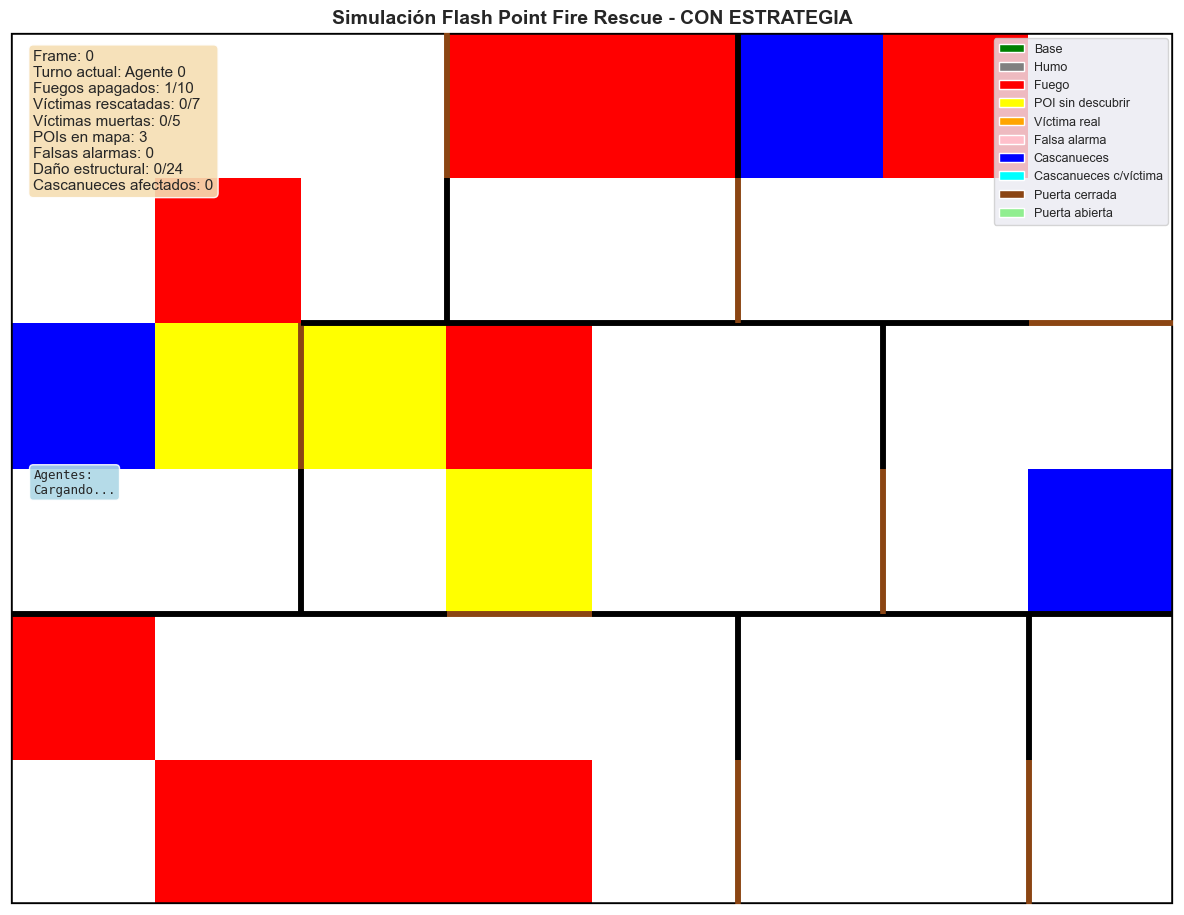

In [94]:
# PARTE 5: Animación

model_info = model.datacollector.get_model_vars_dataframe()
agent_info = model.datacollector.get_agent_vars_dataframe()

fig, axs = plt.subplots(figsize=(12, 10))
axs.set_xticks([])
axs.set_yticks([])
axs.set_title("Simulación Flash Point Fire Rescue - CON ESTRATEGIA", fontsize=14, fontweight='bold')
colors = ['white', 'gray', 'red', 'yellow', 'orange', 'pink', 'blue', 'cyan', 'green']

n_bins = 9
cmap = matplotlib.colors.ListedColormap(colors[:n_bins])

patch = plt.imshow(model_info.iloc[0]['Grid'], cmap=cmap, vmin=0, vmax=8, origin='lower')

initial_walls = model_info.iloc[0]['Walls']
draw_walls(axs, initial_walls)

legend_elements = [
    Patch(facecolor='green', label='Base'),
    Patch(facecolor='gray', label='Humo'),
    Patch(facecolor='red', label='Fuego'),
    Patch(facecolor='yellow', label='POI sin descubrir'),
    Patch(facecolor='orange', label='Víctima real'),
    Patch(facecolor='pink', label='Falsa alarma'),
    Patch(facecolor='blue', label='Cascanueces'),
    Patch(facecolor='cyan', label='Cascanueces c/víctima'),
    Patch(facecolor='#8B4513', label='Puerta cerrada'),
    Patch(facecolor='#90EE90', label='Puerta abierta')
]

def animate(i):
    axs.clear()
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_title("Simulación Flash Point Fire Rescue - CON ESTRATEGIA", fontsize=14, fontweight='bold')

    axs.imshow(model_info.iloc[i]['Grid'], cmap=cmap, vmin=0, vmax=8, origin='lower')

    current_walls = model_info.iloc[i]['Walls']
    draw_walls(axs, current_walls)

    axs.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=9)

    fuegos = model_info.iloc[i]['FuegosApagados']
    victimas_rescatadas = model_info.iloc[i]['VictimasRescatadas']
    victimas_mapa = model_info.iloc[i]['VictimasEnMapa']
    falsas_alarmas = model_info.iloc[i]['FalsasAlarmas']
    victimas_muertas = model_info.iloc[i]['VictimasMuertas']
    danio = model_info.iloc[i]['DanioEstructural']
    turno = model_info.iloc[i]['TurnoActual']
    cascanueces_afectados = model_info.iloc[i]['CascanuecesAfectados']

    step_info = axs.text(0.02, 0.98, '', transform=axs.transAxes,
                         fontsize=11, verticalalignment='top',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

    step_info.set_text(
        f'Frame: {i}\n'
        f'Turno actual: Agente {turno}\n'
        f'Fuegos apagados: {fuegos}/10\n'
        f'Víctimas rescatadas: {victimas_rescatadas}/{model.victimas_totales}\n'
        f'Víctimas muertas: {victimas_muertas}/5\n'
        f'POIs en mapa: {victimas_mapa}\n'
        f'Falsas alarmas: {falsas_alarmas}\n'
        f'Daño estructural: {danio}/24\n'
        f'Cascanueces afectados: {cascanueces_afectados}'
    )

    try:
        agent_data = agent_info.xs(i, level='Step')
        
        # Separar por rol
        apagafuegos_ids = [agent.unique_id for agent in model.lista_agentes if agent.rol == "apagafuegos"]
        rescatistas_ids = [agent.unique_id for agent in model.lista_agentes if agent.rol == "rescatista"]
        
        pa_info = "AGENTES CON ESTRATEGIA\n" + "=" * 40 + "\n"
        
        # Mostrar apagafuegos
        pa_info += "\n🔥 APAGAFUEGOS:\n"
        for agent_id in sorted(apagafuegos_ids):
            if agent_id in agent_data.index:
                pa = int(agent_data.loc[agent_id, 'PA'])
                fuegos_ag = int(agent_data.loc[agent_id, 'FuegosApagados'])
                humos_ag = int(agent_data.loc[agent_id, 'HumosApagados'])
                puertas_ag = int(agent_data.loc[agent_id, 'PuertasAbiertas'])
                veces_afectado = int(agent_data.loc[agent_id, 'VecesAfectado'])

                if agent_id == turno:
                    pa_info += f"> Ag.{agent_id}: PA={pa}/4 *\n"
                else:
                    pa_info += f"  Ag.{agent_id}: PA={pa}/4\n"
                pa_info += f"  🔥:{fuegos_ag} 💨:{humos_ag} 🚪:{puertas_ag}"
                if veces_afectado > 0:
                    pa_info += f" 💥:{veces_afectado}"
                pa_info += "\n"
        
        # Mostrar rescatistas
        pa_info += "\n🚑 RESCATISTAS:\n"
        for agent_id in sorted(rescatistas_ids):
            if agent_id in agent_data.index:
                pa = int(agent_data.loc[agent_id, 'PA'])
                victimas_ag = int(agent_data.loc[agent_id, 'VictimasSalvadas'])
                puertas_ag = int(agent_data.loc[agent_id, 'PuertasAbiertas'])
                veces_afectado = int(agent_data.loc[agent_id, 'VecesAfectado'])

                if agent_id == turno:
                    pa_info += f"> Ag.{agent_id}: PA={pa}/4 *\n"
                else:
                    pa_info += f"  Ag.{agent_id}: PA={pa}/4\n"
                pa_info += f"  👥:{victimas_ag} 🚪:{puertas_ag}"
                if veces_afectado > 0:
                    pa_info += f" 💥:{veces_afectado}"
                pa_info += "\n"

        pa_stats = axs.text(0.02, 0.50, '', transform=axs.transAxes,
                            fontsize=9, verticalalignment='top', family='monospace',
                            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
        pa_stats.set_text(pa_info)
    except Exception as e:
        pa_stats = axs.text(0.02, 0.50, '', transform=axs.transAxes,
                            fontsize=9, verticalalignment='top', family='monospace',
                            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
        pa_stats.set_text("Agentes:\nCargando...")

print("\n" + "="*60)
print("GENERANDO ANIMACIÓN...")
print("="*60)

anim = animation.FuncAnimation(fig, animate, frames=len(model_info),
                               interval=300, blit=False, repeat=True)

plt.tight_layout()

print("✅ Animación lista. Ejecuta 'anim' en la siguiente celda para visualizar.")
print("="*60 + "\n")


In [95]:
anim

C:\Users\sebas\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py:406: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans Mono.
  return method()
C:\Users\sebas\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py:406: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans Mono.
  return method()
C:\Users\sebas\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py:406: UserWarning: Glyph 128682 (\N{DOOR}) missing from font(s) DejaVu Sans Mono.
  return method()
C:\Users\sebas\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py:406: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans Mono.
  return method()
C:\Users\sebas\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py:406: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  return method()
C:\Users\sebas\AppData\Roaming\Py

In [96]:
NUM_RUNS = 100
MAX_STEPS = 200

results = []

for i in range(NUM_RUNS):
    model = FoodCollectionModel(
        width=8,
        height=6,
        num_agents=6,
        num_apagafuegos=3,
        num_rescatistas=3
    )

    steps = 0
    while not model.game_over() and steps < MAX_STEPS:
        model.step()
        steps += 1

    # Guardamos estadísticas de esta corrida
    results.append({
        "rescued": model.victims_rescued,
        "dead": model.victimas_muertas,
        "total_victims": model.victimas_totales,
        "fires_out": model.fuegos_totales_apagados,
        "false_alarms": model.falsas_alarmas_descubiertas,
        "damage": model.damage_count,
        "win": model.damage_count < 24 and model.victimas_muertas < 4
    })

print("Batch run terminado.")


Batch run terminado.


In [97]:
df = pd.DataFrame(results)

total_rescued = df["rescued"].sum()
total_dead = df["dead"].sum()
total_fires_out = df["fires_out"].sum()
total_false_alarms = df["false_alarms"].sum()
total_damage = df["damage"].sum()

wins = df["win"].sum()
winrate = wins / NUM_RUNS * 100

print("\n===== ESTADÍSTICAS TOTALES =====")
print(f"Víctimas rescatadas: {total_rescued}")
print(f"Víctimas muertas: {total_dead}")
print(f"Fuegos apagados: {total_fires_out}")
print(f"Falsas alarmas descubiertas: {total_false_alarms}")
print(f"Daño total acumulado: {total_damage}")
print(f"\nVictorias: {wins}/{NUM_RUNS}  ({winrate:.2f}%)")



===== ESTADÍSTICAS TOTALES =====
Víctimas rescatadas: 115
Víctimas muertas: 194
Fuegos apagados: 2594
Falsas alarmas descubiertas: 297
Daño total acumulado: 2444

Victorias: 0/100  (0.00%)


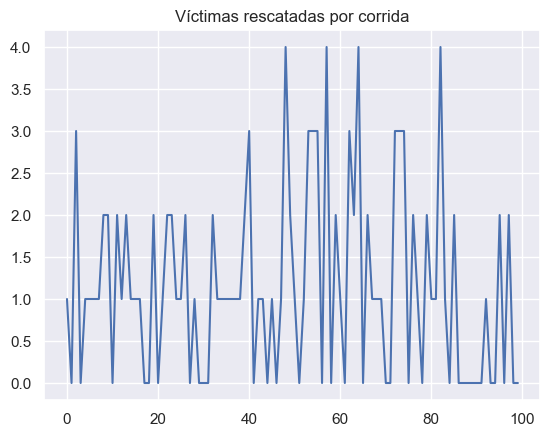

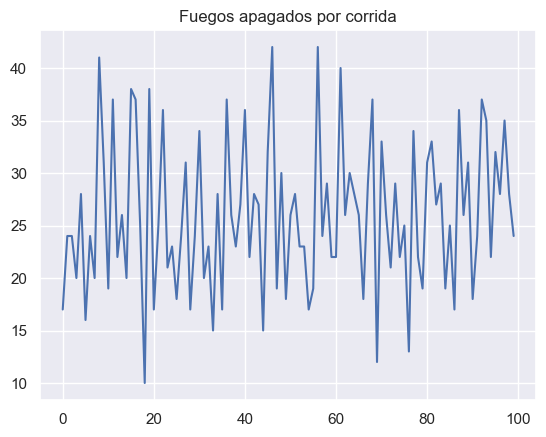

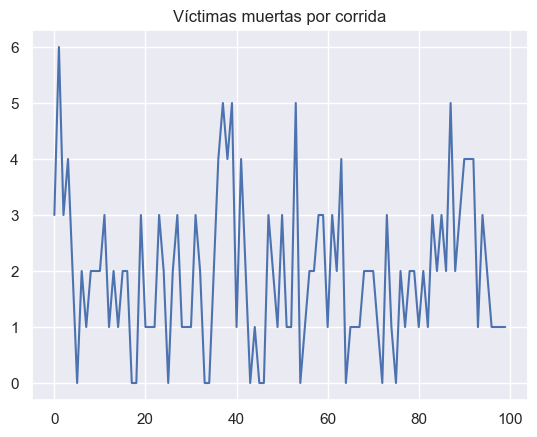

In [98]:
df["rescued"].plot(kind="line")
plt.title("Víctimas rescatadas por corrida")
plt.show()

df["fires_out"].plot(kind="line")
plt.title("Fuegos apagados por corrida")
plt.show()

df["dead"].plot(kind="line")
plt.title("Víctimas muertas por corrida")
plt.show()